## sandbox workspace for function training 



In [7]:
import pysofaconventions as sofa
import soundfile as sf
import numpy as np
import os
import glob
from scipy.io import wavfile
import importlib
import matplotlib.pyplot as plt
import data_preprocessing; importlib.reload(data_preprocessing); import data_preprocessing
import feature_extract; importlib.reload(feature_extract); import feature_extract
import viz; importlib.reload(viz); import viz
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error
# from sklearn.decomposition import PCA

data_preprocessing.fix_stereo_wav("/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/online_samples/preprocessed/sharp-sweep_0_0.wav",
                                  "/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/online_samples/preprocessed/sharp-sweep_0_0_fixed.wav")


RuntimeError: Couldn't find 'data' chunk

In [9]:
import scipy.io.wavfile as wavfile
output_filename = 'metronome.txt'
import numpy as np



def get_raw_samples_numpy(filename):
    """Reads a WAV file and returns the sample data as a NumPy array."""
    try:
        # rate is the sampling frequency (e.g., 44100)
        # data is the NumPy array containing the samples
        rate, data = wavfile.read(filename)
        original_dtype = data.dtype
        print("original_dtype = ", original_dtype)
        print("original size = ", len(data))
        print(data.flatten())
        samples = data.flatten()
        data = np.array(data)
        with open(output_filename, 'wb') as f:
            f.write(data.flatten().tobytes())
            np.savetxt(output_filename, samples, fmt='%d', delimiter='\n')
        return data


    except Exception as e:
        print(f"Error reading WAV file: {e}")
        return None


data = get_raw_samples_numpy("/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/online_samples/preprocessed/metronome.wav")
#save data to a text file


original_dtype =  int16
original size =  44100
[ 0 -1 -5 ...  0 -1  1]


data_start: 46 file_len: 778752 header data_size: 3822215540
raw_audio_len: 778706 mod2: 0 mod4: 2
dropping one trailing sample to make stereo frames align
stereo shape: (194676, 2)
data_start: 46 file_len: 778752 header data_size: 3822215540
raw_audio_len: 778706 mod2: 0 mod4: 2
dropping one trailing sample to make stereo frames align
stereo shape: (194676, 2)


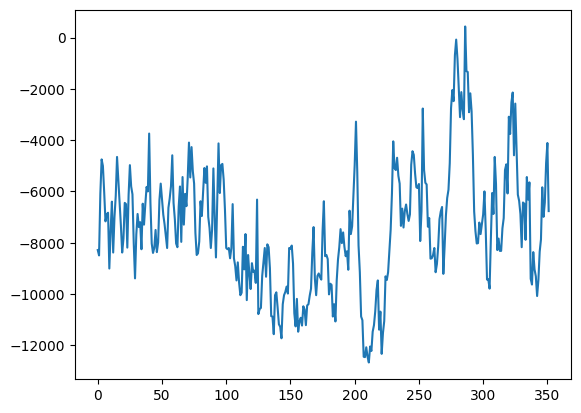

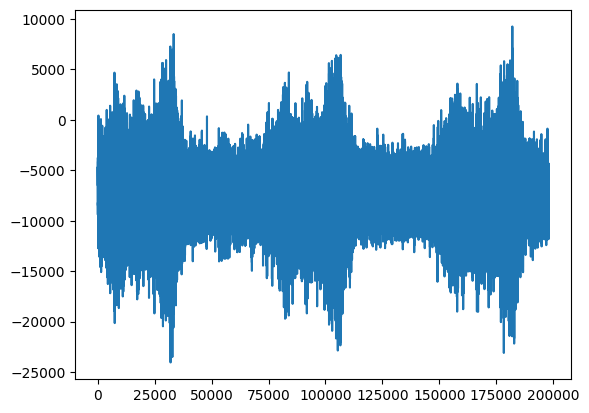

linear
Label shape: (394, 3)
Features shape: (394, 53)


In [1]:
import pysofaconventions as sofa
import soundfile as sf
import numpy as np
import os
import glob
from scipy.io import wavfile
import importlib
import matplotlib.pyplot as plt
import data_preprocessing; importlib.reload(data_preprocessing); import data_preprocessing
import feature_extract; importlib.reload(feature_extract); import feature_extract
import viz; importlib.reload(viz); import viz
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
def onset_window(x, fs, win_ms=8):
    """Extract window starting at onset"""
    x = x.astype(np.float32)
    env = np.abs(x)
    
    kernel = np.ones(512, dtype=np.float32) / 512.0
    env_smooth = np.convolve(env, kernel, mode="same")
    
    thr = 0.1 * np.max(env_smooth)
    idx0 = int(np.argmax(env_smooth > thr))
    
    Nwin = int(win_ms * 1e-3 * fs)
    start = max(0, idx0)
    end = min(len(x), start + Nwin)
    seg = x[start:end]
    
    if len(seg) < Nwin:
        seg = np.pad(seg, (0, Nwin - len(seg)))
    
    return seg
def extract_features_simple(left, right, fs, n_bands=8):
    """
    Simpler version using FFT instead of gammatone
    Easier to debug
    """
    from scipy.fft import rfft, rfftfreq
    
    # FFT of both channels
    L_fft = np.abs(rfft(left))
    R_fft = np.abs(rfft(right))
    freqs = rfftfreq(len(left), 1/fs)
    
    # Split into bands
    band_edges = np.logspace(np.log10(200), np.log10(8000), n_bands + 1)
    
    ild_per_band = []
    for i in range(n_bands):
        # Find frequencies in this band
        mask = (freqs >= band_edges[i]) & (freqs < band_edges[i+1])
        
        # Sum energy in band
        L_energy = np.sum(L_fft[mask]**2)
        R_energy = np.sum(R_fft[mask]**2)
        
        # ILD
        epsilon = 1e-10
        ild = np.log((L_energy + epsilon) / (R_energy + epsilon))
        ild_per_band.append(ild)
    
    ild_per_band = np.array(ild_per_band)
    
    # Overall ILD
    overall_ild = np.log((np.sum(L_fft**2) + 1e-10) / (np.sum(R_fft**2) + 1e-10))
    
    # Spectral tilt
    high_energy = np.sum(L_fft[freqs > 4000]**2)
    low_energy = np.sum(L_fft[freqs < 1000]**2)
    tilt = high_energy / (low_energy + 1e-10)
    
    features = np.concatenate([ild_per_band, [overall_ild], [tilt]])
    return features

paths = glob.glob(
    "/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/training_audio/raw/collected/*.wav",
    recursive=True,
)
elev_list = []
horiz_list = []
feat_list = []
label_list   = []
for path in paths: 
    # if "H10" in path and"005" in path:
    left, right, sample_rate, label = data_preprocessing.reformat_wav(path)
    left_seg = onset_window(left, sample_rate, win_ms=8)
    right_seg = onset_window(right, sample_rate, win_ms=8)  
    left_clean = feature_extract.spectral_subtract(left_seg, sample_rate, noise_dur_sec=0.05)
    right_clean = feature_extract.spectral_subtract(right_seg, sample_rate, noise_dur_sec=0.05) 
    feat_vec = extract_features_simple(left_clean,right_clean,sample_rate,n_bands=50)
    itd_sec, _ = feature_extract.compute_ITD(left_seg, right_seg, sample_rate, max_ITD_spec=0.001)
    itd_feature = np.array([itd_sec])
    feat_vec = np.concatenate((itd_feature, feat_vec), axis=0)
    elev_list.append(label[0])
    horiz_list.append(label[1])
    feat_list.append(feat_vec)
    label_list.append(label)

    # print(spec_feat.shape)

elev = np.array(elev_list, dtype=float)
horiz = np.array(horiz_list, dtype=float)
# features = np.stack(feat_list,  axis=0)   # shape (N_samples, D_features)

# print("features shape:", features.shape)
label = np.stack(label_list, axis=0)
print("Label shape:", label.shape)
features = np.stack(feat_list, axis=0)
print("Features shape:", features.shape)

In [10]:
# --- Correlation Code to Run After Generating Features (X) ---
D = features.shape[1]  # Should be 52 to 102 now

# Labels
elev = np.array(elev_list, dtype=float)
horiz = np.array(horiz_list, dtype=float) # Horizontal Index (0-9)

corr_elev = []
corr_horiz = []

for j in range(D):
    f = features[:, j]
    if np.std(f) < 1e-8:
        corr_elev.append(0.0)
        corr_horiz.append(0.0)
        continue
        
    # Calculate Pearson R between feature j and elevation/horizontal labels
    ce = np.corrcoef(f, elev)[0, 1]
    ca = np.corrcoef(f, horiz)[0, 1]
    
    corr_elev.append(ce)
    corr_horiz.append(ca)

corr_elev = np.array(corr_elev)
corr_horiz = np.array(corr_horiz)

# Find the indices of the top features by absolute correlation
# E.g., Top 3 for Elevation and Top 3 for Horizontal, excluding the ITD feature (index 0)
top_k_elev_indices = np.argsort(-np.abs(corr_elev))[1:4] 
top_k_horiz_indices = np.argsort(-np.abs(corr_horiz))[1:4] 

print(f"Top 3 Elevation Feature Indices (excluding ITD): {top_k_elev_indices}")
print(f"Top 3 Horizontal Feature Indices (excluding ITD): {top_k_horiz_indices}")

Top 3 Elevation Feature Indices (excluding ITD): [31 50 25]
Top 3 Horizontal Feature Indices (excluding ITD): [ 9 50 52]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, hilbert
from scipy.io import wavfile
import glob
import re
import os
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import pickle
import math



# ============================================================================
# FEATURE EXTRACTION: Gammatone Filterbank
# ============================================================================

def gammatone_impulse_response(fc, fs, duration=0.02, n=4, phase=0):
    """
    Generate gammatone filter impulse response
    Mimics human cochlear filtering - each frequency channel has specific bandwidth
    
    fc: center frequency (Hz)
    fs: sample rate
    duration: filter length (seconds)
    n: filter order (4 is physiologically realistic)
    """
    t = np.arange(0, duration, 1/fs)
    
    # Equivalent rectangular bandwidth (ERB) - how wide each cochlear filter is
    # Formula from Glasberg & Moore (1990)
    erb = 24.7 * (4.37 * fc / 1000 + 1)
    
    # Gammatone formula
    a = np.pi * erb / fs
    gain = (a ** n) / math.factorial(n-1)
    
    envelope = gain * (t ** (n-1)) * np.exp(-2 * np.pi * erb * t)
    carrier = np.cos(2 * np.pi * fc * t + phase)
    
    return envelope * carrier


def gammatone_filterbank(signal, fs, n_bands=8, fmin=200, fmax=8000):
    """
    Filter signal through gammatone filterbank
    Returns energy in each frequency band for left and right channels
    
    Why gammatone? 
    - Models human cochlea better than uniform FFT bins
    - Captures spectral shape efficiently
    - Fast to implement on MCU (just FIR filters)
    """
    # Logarithmically spaced center frequencies (like cochlea)
    center_freqs = np.logspace(np.log10(fmin), np.log10(fmax), n_bands)
    
    energies = np.zeros(n_bands)
    
    for i, fc in enumerate(center_freqs):
        # Generate filter
        h = gammatone_impulse_response(fc, fs, duration=0.02)
        
        # Filter signal (convolution)
        filtered = np.convolve(signal, h, mode='same')
        
        # Extract energy (RMS)
        energies[i] = np.sqrt(np.mean(filtered**2))
    
    return energies, center_freqs

def extract_features_simple(left, right, fs, n_bands=8):
    """
    Simpler version using FFT instead of gammatone
    Easier to debug
    """
    from scipy.fft import rfft, rfftfreq
    
    # FFT of both channels
    L_fft = np.abs(rfft(left))
    R_fft = np.abs(rfft(right))
    freqs = rfftfreq(len(left), 1/fs)
    
    # Split into bands
    band_edges = np.logspace(np.log10(200), np.log10(8000), n_bands + 1)
    
    ild_per_band = []
    for i in range(n_bands):
        # Find frequencies in this band
        mask = (freqs >= band_edges[i]) & (freqs < band_edges[i+1])
        
        # Sum energy in band
        L_energy = np.sum(L_fft[mask]**2)
        R_energy = np.sum(R_fft[mask]**2)
        
        # ILD
        epsilon = 1e-10
        ild = np.log((L_energy + epsilon) / (R_energy + epsilon))
        ild_per_band.append(ild)
    
    ild_per_band = np.array(ild_per_band)
    
    # Overall ILD
    overall_ild = np.log((np.sum(L_fft**2) + 1e-10) / (np.sum(R_fft**2) + 1e-10))
    
    # Spectral tilt
    high_energy = np.sum(L_fft[freqs > 4000]**2)
    low_energy = np.sum(L_fft[freqs < 1000]**2)
    tilt = high_energy / (low_energy + 1e-10)
    
    features = np.concatenate([ild_per_band, [overall_ild], [tilt]])
    return features
def extract_features(left, right, fs, n_bands=8):
    """
    Extract features from stereo recording - FIXED VERSION
    """
    # Get energy in each frequency band
    left_energies, freqs = gammatone_filterbank(left, fs, n_bands=n_bands)
    right_energies, _ = gammatone_filterbank(right, fs, n_bands=n_bands)
    
    epsilon = 1e-10
    
    # Normalize energies so they're comparable across bands
    # This prevents low-freq dominance
    left_energies_norm = left_energies / (np.sum(left_energies) + epsilon)
    right_energies_norm = right_energies / (np.sum(right_energies) + epsilon)
    
    # ILD per band using NORMALIZED energies
    ild_per_band = np.log((left_energies_norm + epsilon) / (right_energies_norm + epsilon))
    
    # Overall ILD (broadband)
    overall_ild = np.log((np.sum(left_energies) + epsilon) / (np.sum(right_energies) + epsilon))
    
    # Better spectral features for elevation
    # Instead of ratio, use normalized energy distribution
    spectral_centroid_left = np.sum(left_energies_norm * np.arange(n_bands)) / n_bands
    spectral_centroid_right = np.sum(right_energies_norm * np.arange(n_bands)) / n_bands
    
    # Also add: difference in spectral shape between ears (elevation cue)
    spectral_diff = spectral_centroid_left - spectral_centroid_right
    
    features = np.concatenate([
        ild_per_band,              # 8 values: per-band ILD
        [overall_ild],             # 1 value: broadband ILD
        [spectral_centroid_left],  # 1 value: where is energy concentrated (elevation)
    ])
    
    return features


# Also let's add more bands and better training
def train_model(X, y, model_type='mlp'):
    """Train with better hyperparameters"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y[:, 1]  # Stratify by horizontal
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\nTraining {model_type} model...")
    
    if model_type == 'mlp':
        # Try bigger network since we have small dataset
        model = MLPRegressor(
            hidden_layer_sizes=(32, 32, 16),  # Deeper network
            activation='relu',
            solver='adam',
            learning_rate_init=0.001,
            max_iter=2000,  # More iterations
            random_state=42,
            early_stopping=True,
            validation_fraction=0.15,
            n_iter_no_change=50,  # More patience
            alpha=0.01,  # L2 regularization
            verbose=True
        )
    else:
        from sklearn.linear_model import Ridge
        model = Ridge(alpha=10.0)  # Stronger regularization
    
    model.fit(X_train_scaled, y_train)
    
    y_pred_test = model.predict(X_test_scaled)
    y_pred_test_round = np.rint(y_pred_test).astype(int)
    y_pred_test_round[:, 0] = np.clip(y_pred_test_round[:, 0], 0, 19)
    y_pred_test_round[:, 1] = np.clip(y_pred_test_round[:, 1], 0, 9)
    
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    # Separate accuracies
    elev_mae = np.mean(np.abs(y_pred_test_round[:, 0] - y_test[:, 0]))
    horiz_mae = np.mean(np.abs(y_pred_test_round[:, 1] - y_test[:, 1]))
    
    elev_acc = np.mean(y_pred_test_round[:, 0] == y_test[:, 0])
    horiz_acc = np.mean(y_pred_test_round[:, 1] == y_test[:, 1])
    both_acc = np.mean((y_pred_test_round[:, 0] == y_test[:, 0]) & 
                       (y_pred_test_round[:, 1] == y_test[:, 1]))
    
    # Check if within 1 index (close enough)
    elev_close = np.mean(np.abs(y_pred_test_round[:, 0] - y_test[:, 0]) <= 1)
    horiz_close = np.mean(np.abs(y_pred_test_round[:, 1] - y_test[:, 1]) <= 1)
    
    print(f"\nResults:")
    print(f"  Test MAE: {mae_test:.3f}")
    print(f"  Elevation MAE: {elev_mae:.2f} indices")
    print(f"  Horizontal MAE: {horiz_mae:.2f} indices")
    print(f"\nExact accuracy:")
    print(f"  Elevation: {elev_acc:.1%}")
    print(f"  Horizontal: {horiz_acc:.1%}")
    print(f"  Both correct: {both_acc:.1%}")
    print(f"\nWithin 1 index (acceptable):")
    print(f"  Elevation: {elev_close:.1%}")
    print(f"  Horizontal: {horiz_close:.1%}")
    
    if model_type == 'mlp':
        n_params = sum(w.size for w in model.coefs_) + sum(b.size for b in model.intercepts_)
        print(f"\n  Model parameters: {n_params}")
        print(f"  Model size (float32): {n_params * 4 / 1024:.2f} KB")
    
    # Show confusion: which angles get confused?
    print(f"\nMost common horizontal predictions: {np.bincount(y_pred_test_round[:, 1])}")
    print(f"True horizontal distribution: {np.bincount(y_test[:, 1])}")
    
    return model, scaler, {
        'mae_test': mae_test,
        'elev_acc': elev_acc,
        'horiz_acc': horiz_acc,
        'both_acc': both_acc,
        'elev_close': elev_close,
        'horiz_close': horiz_close,
    }


def onset_window(x, fs, win_ms=8):
    """Extract window starting at onset"""
    x = x.astype(np.float32)
    env = np.abs(x)
    
    kernel = np.ones(512, dtype=np.float32) / 512.0
    env_smooth = np.convolve(env, kernel, mode="same")
    
    thr = 0.1 * np.max(env_smooth)
    idx0 = int(np.argmax(env_smooth > thr))
    
    Nwin = int(win_ms * 1e-3 * fs)
    start = max(0, idx0)
    end = min(len(x), start + Nwin)
    seg = x[start:end]
    
    if len(seg) < Nwin:
        seg = np.pad(seg, (0, Nwin - len(seg)))
    
    return seg


def reformat_wav(data_path):
    """Parse wav file and extract angle labels"""
    sample_rate, data = wavfile.read(data_path)
    
    # Handle both mono and stereo
    if len(data.shape) == 1:
        left = data
        right = data
    else:
        left = data[:,0]
        right = data[:,1]
    
    filename = os.path.basename(data_path)
    
    if "collected" in data_path:
        # Parse primitive type
        if "dtmf" in data_path:
            primitive_name = "dtmf"
        elif "sine_16" in data_path or "sine" in data_path:
            primitive_name = "sine"
        elif "pluck" in data_path:
            primitive_name = "pluck"
        elif "linear_p5_200_p1_1400" in data_path or "linear" in data_path:
            primitive_name = "linear"
        else:
            raise ValueError(f"Could not parse primitive name from {filename}")
        
        # Parse angles
        m = re.search(r'_(\d+)_(\d+)\.wav$', filename)
        if m is None:
            m = re.search(r'_(\d+)-(\d+)\.wav$', filename)
        if m is None:
            raise ValueError(f"Could not parse angles from {filename}")
        
        elev_angle = int(m.group(1))
        horiz_angle = int(m.group(2))
        label = [elev_angle, horiz_angle, primitive_name]
        
    elif "from_KEMAR" in data_path:
        elev_match = re.search(r'H([+-]?\d+)', filename)
        horiz_match = re.search(r'e([+-]?\d+)', filename)
        
        if elev_match is None or horiz_match is None:
            raise ValueError(f"Could not parse KEMAR angles from {filename}")
        
        elev_angle = int(elev_match.group(1))
        horiz_angle = int(horiz_match.group(1))
        label = [elev_angle, horiz_angle, "kemar"]
        
    else:
        raise ValueError(f"Unexpected data source for {filename}")
    
    return left, right, sample_rate, label


# ============================================================================
# MODEL TRAINING
# ============================================================================

def load_dataset(data_path_pattern, n_bands=8, win_ms=8, max_files=None, debug=False):
    """Load all audio files and extract features"""
    paths = glob.glob(data_path_pattern, recursive=True)
    
    if len(paths) == 0:
        print(f"ERROR: No files found matching pattern: {data_path_pattern}")
        return None, None, None
    
    if max_files:
        paths = paths[:max_files]
    
    X_list = []
    y_list = []
    metadata_list = []
    error_count = 0
    
    print(f"Found {len(paths)} audio files")
    
    if debug:
        print("\nFirst 3 filenames:")
        for p in paths[:3]:
            print(f"  {os.path.basename(p)}")
    
    print(f"\nProcessing files...")
    
    for i, path in enumerate(paths):
        if i % 50 == 0:
            print(f"  {i}/{len(paths)} (errors: {error_count})")
        
        try:
            left, right, fs, label = reformat_wav(path)
            
            left_seg = onset_window(left, fs, win_ms=win_ms)
            right_seg = onset_window(right, fs, win_ms=win_ms)
            
            max_val = max(np.max(np.abs(left_seg)), np.max(np.abs(right_seg)), 1e-12)
            left_seg = left_seg / max_val
            right_seg = right_seg / max_val
            
            features = extract_features_simple(left_seg, right_seg, fs, n_bands=n_bands)
            
            X_list.append(features)
            y_list.append([label[0], label[1]])
            metadata_list.append(label)
            
        except Exception as e:
            error_count += 1
            if debug or error_count <= 5:
                print(f"  ERROR processing {os.path.basename(path)}: {e}")
            continue
    
    if len(X_list) == 0:
        print(f"\nERROR: No files successfully processed!")
        print(f"Total errors: {error_count}/{len(paths)}")
        return None, None, None
    
    X = np.vstack(X_list)
    y = np.array(y_list)
    
    print(f"\nDataset loaded successfully:")
    print(f"  Files processed: {len(X_list)}/{len(paths)}")
    print(f"  Errors: {error_count}")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    
    return X, y, metadata_list



# ============================================================================
# MAIN TRAINING SCRIPT
# ============================================================================

if __name__ == "__main__":
    # UPDATE THIS PATH
    data_path = "/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/training_audio/raw/collected/*.wav"
    
    print("=" * 60)
    print("HRTF LOCALIZATION - EMBEDDED DEPLOYMENT")
    print("=" * 60)
    
    X, y, metadata = load_dataset(
        data_path,
        n_bands=8,
        win_ms=8,
        max_files=None,
        debug=True
    )
    
    if X is None:
        print("\n❌ Dataset loading failed")
        import sys
        sys.exit(1)
    
    model, scaler, metrics = train_model(X, y, model_type='mlp')
    
    with open('hrtf_model.pkl', 'wb') as f:
        pickle.dump({'model': model, 'scaler': scaler, 'metrics': metrics}, f)
    print("\nSaved model to hrtf_model.pkl")

HRTF LOCALIZATION - EMBEDDED DEPLOYMENT
Found 394 audio files

First 3 filenames:
  linear_p5_200_p1_1400_sine_chirp_7_9.wav
  dtmf_5_4.wav
  sine_16_3_9.wav

Processing files...
  0/394 (errors: 0)
  50/394 (errors: 0)
  100/394 (errors: 0)
  150/394 (errors: 0)
  200/394 (errors: 0)
  250/394 (errors: 0)
  300/394 (errors: 0)
  350/394 (errors: 0)

Dataset loaded successfully:
  Files processed: 394/394
  Errors: 0
  X shape: (394, 10)
  y shape: (394, 2)

Training mlp model...
Iteration 1, loss = 16.16142339
Validation score: -3.628179
Iteration 2, loss = 15.78236346
Validation score: -3.510221
Iteration 3, loss = 15.41081326
Validation score: -3.391426
Iteration 4, loss = 15.05569190
Validation score: -3.270983
Iteration 5, loss = 14.69560824
Validation score: -3.151386
Iteration 6, loss = 14.34323158
Validation score: -3.030766
Iteration 7, loss = 13.99126999
Validation score: -2.911043
Iteration 8, loss = 13.64647082
Validation score: -2.790933
Iteration 9, loss = 13.29665841
Val

In [22]:
# Check the actual angle distribution
print("\n" + "="*60)
print("DATASET ANALYSIS")
print("="*60)

unique_angles = {}
for i, meta in enumerate(metadata):
    elev, horiz, prim = meta
    key = (elev, horiz)
    if key not in unique_angles:
        unique_angles[key] = []
    unique_angles[key].append(prim)

print(f"Total unique angle combinations: {len(unique_angles)}")
print(f"Samples per angle (avg): {len(metadata) / len(unique_angles):.1f}")

# Show some examples
print("\nFirst 10 angle combinations:")
for i, (angle, prims) in enumerate(list(unique_angles.items())[:10]):
    print(f"  Elev={angle[0]:2d}, Horiz={angle[1]:2d}: {len(prims)} samples ({set(prims)})")

# Check if certain primitives work better
from collections import defaultdict
by_primitive = defaultdict(list)
for i, meta in enumerate(metadata):
    by_primitive[meta[2]].append(i)

print(f"\nSamples per primitive:")
for prim, indices in by_primitive.items():
    print(f"  {prim}: {len(indices)} samples")

    # BETTER APPROACH: Train separate model for each primitive type
# This way we don't need invariance - just specialized models

def train_per_primitive_models(X, y, metadata):
    """Train one model per sound primitive"""
    from collections import defaultdict
    
    # Group data by primitive
    by_primitive = defaultdict(lambda: {'X': [], 'y': []})
    for i, meta in enumerate(metadata):
        prim = meta[2]
        by_primitive[prim]['X'].append(X[i])
        by_primitive[prim]['y'].append(y[i])
    
    models = {}
    scalers = {}
    
    for prim, data in by_primitive.items():
        print(f"\n{'='*60}")
        print(f"TRAINING MODEL FOR: {prim.upper()}")
        print(f"{'='*60}")
        print(f"Samples: {len(data['X'])}")
        
        if len(data['X']) < 20:
            print(f"⚠️  Too few samples, skipping {prim}")
            continue
        
        X_prim = np.array(data['X'])
        y_prim = np.array(data['y'])
        
        # Use simpler model for small datasets
        X_train, X_test, y_train, y_test = train_test_split(
            X_prim, y_prim, test_size=0.2, random_state=42
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Smaller model for small dataset
        model = MLPRegressor(
            hidden_layer_sizes=(16, 8),
            activation='relu',
            max_iter=1000,
            random_state=42,
            early_stopping=True,
            alpha=0.1,  # Heavy regularization
            verbose=False
        )
        
        model.fit(X_train_scaled, y_train)
        
        y_pred = model.predict(X_test_scaled)
        y_pred_round = np.rint(y_pred).astype(int)
        y_pred_round[:, 0] = np.clip(y_pred_round[:, 0], 0, 19)
        y_pred_round[:, 1] = np.clip(y_pred_round[:, 1], 0, 9)
        
        horiz_acc = np.mean(y_pred_round[:, 1] == y_test[:, 1])
        elev_acc = np.mean(y_pred_round[:, 0] == y_test[:, 0])
        
        print(f"  Horizontal accuracy: {horiz_acc:.1%}")
        print(f"  Elevation accuracy: {elev_acc:.1%}")
        
        models[prim] = model
        scalers[prim] = scaler
    
    return models, scalers

# Train per-primitive
models_per_prim, scalers_per_prim = train_per_primitive_models(X, y, metadata)

# Save
with open('hrtf_models_per_primitive.pkl', 'wb') as f:
    pickle.dump({
        'models': models_per_prim,
        'scalers': scalers_per_prim
    }, f)
print("\nSaved per-primitive models")


DATASET ANALYSIS
Total unique angle combinations: 100
Samples per angle (avg): 3.9

First 10 angle combinations:
  Elev= 7, Horiz= 9: 4 samples ({'pluck', 'sine', 'dtmf'})
  Elev= 5, Horiz= 4: 4 samples ({'dtmf', 'pluck', 'sine'})
  Elev= 3, Horiz= 9: 4 samples ({'pluck', 'sine', 'dtmf'})
  Elev= 3, Horiz= 8: 4 samples ({'pluck', 'sine', 'dtmf'})
  Elev= 9, Horiz= 6: 4 samples ({'pluck', 'sine', 'dtmf'})
  Elev= 7, Horiz= 6: 4 samples ({'dtmf', 'pluck', 'sine'})
  Elev= 9, Horiz= 2: 4 samples ({'pluck', 'sine', 'dtmf'})
  Elev= 9, Horiz= 3: 4 samples ({'pluck', 'sine', 'dtmf'})
  Elev= 1, Horiz= 0: 4 samples ({'dtmf', 'pluck', 'sine'})
  Elev= 3, Horiz= 2: 4 samples ({'dtmf', 'pluck', 'sine'})

Samples per primitive:
  sine: 198 samples
  dtmf: 98 samples
  pluck: 98 samples

TRAINING MODEL FOR: SINE
Samples: 198
  Horizontal accuracy: 20.0%
  Elevation accuracy: 12.5%

TRAINING MODEL FOR: DTMF
Samples: 98
  Horizontal accuracy: 15.0%
  Elevation accuracy: 10.0%

TRAINING MODEL FOR: P


Recording stats:
  Sample rate: 44100 Hz
  Length: 6.15 seconds
  Bit depth: int16
  Left peak: 18672
  Right peak: 17840
  Clipping samples (left): 0
  Clipping samples (right): 0
  SNR estimate (left): 1.9 dB


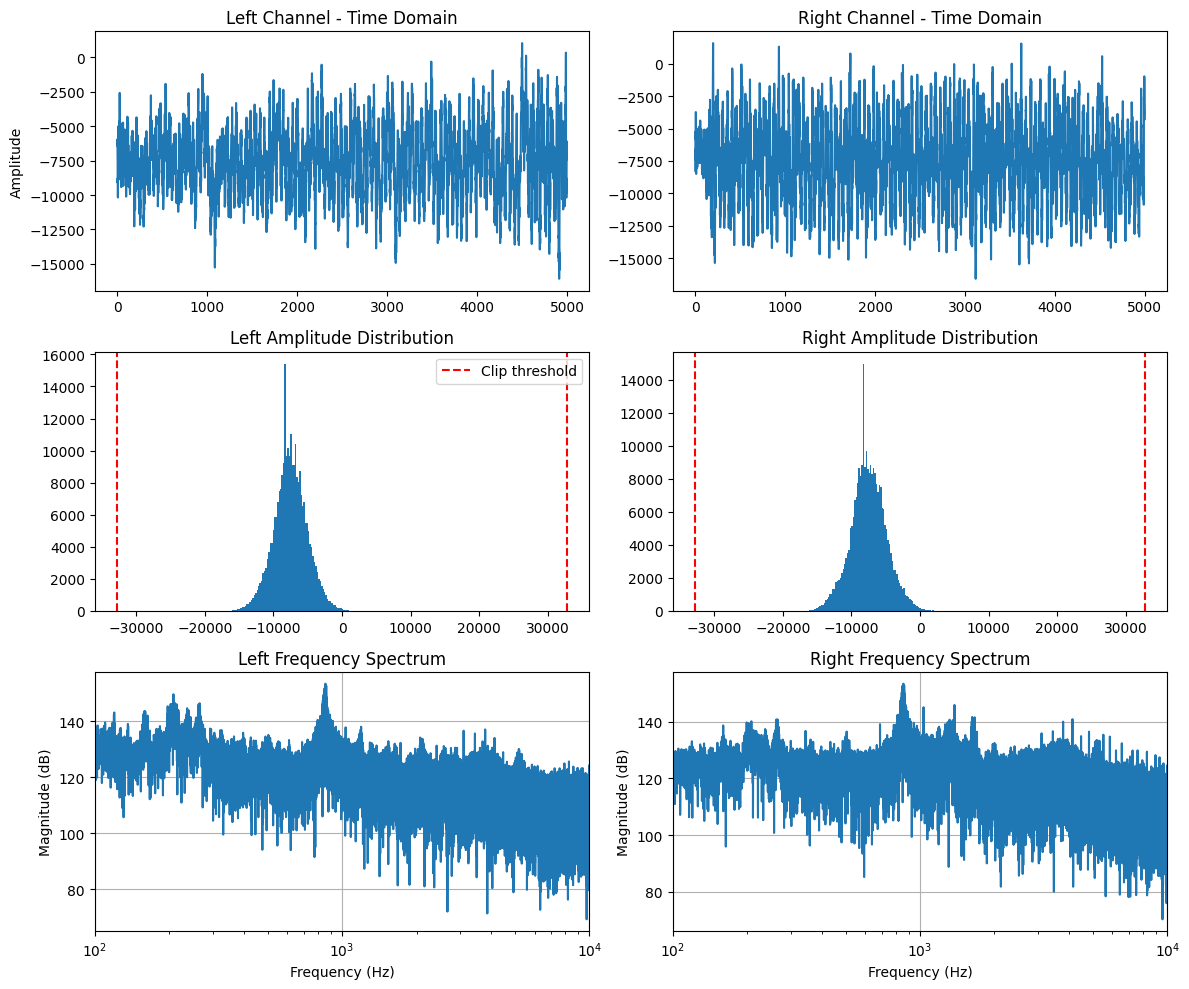

In [3]:
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Pick one file
test_file = "/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/training_audio/raw/collected/sine_16_8_1.wav"  # Update this
fs, data = wavfile.read(test_file)

left = data[:, 0]
right = data[:, 1]

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Time domain
axes[0, 0].plot(left[:5000])
axes[0, 0].set_title('Left Channel - Time Domain')
axes[0, 0].set_ylabel('Amplitude')

axes[0, 1].plot(right[:5000])
axes[0, 1].set_title('Right Channel - Time Domain')

# Check for clipping
left_norm = left / np.max(np.abs(left))
right_norm = right / np.max(np.abs(right))
axes[1, 0].hist(left, bins=100)
axes[1, 0].set_title('Left Amplitude Distribution')
axes[1, 0].axvline(x=32767, color='r', linestyle='--', label='Clip threshold')
axes[1, 0].axvline(x=-32768, color='r', linestyle='--')
axes[1, 0].legend()

axes[1, 1].hist(right, bins=100)
axes[1, 1].set_title('Right Amplitude Distribution')
axes[1, 1].axvline(x=32767, color='r', linestyle='--')
axes[1, 1].axvline(x=-32768, color='r', linestyle='--')

# Frequency domain
from scipy.fft import rfft, rfftfreq
L_fft = np.abs(rfft(left))
R_fft = np.abs(rfft(right))
freqs = rfftfreq(len(left), 1/fs)

axes[2, 0].semilogx(freqs[1:len(freqs)//2], 20*np.log10(L_fft[1:len(L_fft)//2] + 1e-10))
axes[2, 0].set_title('Left Frequency Spectrum')
axes[2, 0].set_xlabel('Frequency (Hz)')
axes[2, 0].set_ylabel('Magnitude (dB)')
axes[2, 0].grid(True)
axes[2, 0].set_xlim([100, 10000])

axes[2, 1].semilogx(freqs[1:len(freqs)//2], 20*np.log10(R_fft[1:len(R_fft)//2] + 1e-10))
axes[2, 1].set_title('Right Frequency Spectrum')
axes[2, 1].set_xlabel('Frequency (Hz)')
axes[2, 1].set_ylabel('Magnitude (dB)')
axes[2, 1].grid(True)
axes[2, 1].set_xlim([100, 10000])

plt.tight_layout()
plt.savefig('recording_quality_check.png', dpi=150)
print(f"\nRecording stats:")
print(f"  Sample rate: {fs} Hz")
print(f"  Length: {len(left)/fs:.2f} seconds")
print(f"  Bit depth: {data.dtype}")
print(f"  Left peak: {np.max(np.abs(left))}")
print(f"  Right peak: {np.max(np.abs(right))}")
print(f"  Clipping samples (left): {np.sum(np.abs(left) >= 32767)}")
print(f"  Clipping samples (right): {np.sum(np.abs(right) >= 32767)}")
print(f"  SNR estimate (left): {20*np.log10(np.std(left) / (np.std(left[:1000]) + 1e-10)):.1f} dB")

plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pickle

# Load the saved model to inspect
with open('hrtf_model.pkl', 'rb') as f:
    saved = pickle.load(f)
    model = saved['model']
    scaler = saved['scaler']

# Let's look at the actual features for a few samples
def diagnose_features(data_path, n_samples=20):
    """Check if features are actually discriminative"""
    import glob
    paths = glob.glob(data_path, recursive=True)[:n_samples]
    
    features_by_angle = {}
    
    for path in paths:
        try:
            left, right, fs, label = reformat_wav(path)
            elev, horiz = label[0], label[1]
            
            left_seg = onset_window(left, fs, win_ms=8)
            right_seg = onset_window(right, fs, win_ms=8)
            
            max_val = max(np.max(np.abs(left_seg)), np.max(np.abs(right_seg)), 1e-12)
            left_seg = left_seg / max_val
            right_seg = right_seg / max_val
            
            features = extract_features_simple(left_seg, right_seg, fs, n_bands=8)
            
            angle_key = (elev, horiz)
            if angle_key not in features_by_angle:
                features_by_angle[angle_key] = []
            features_by_angle[angle_key].append(features)
            
            # Print first few
            if len(features_by_angle) <= 5:
                print(f"\nFile: {os.path.basename(path)}")
                print(f"  Angle: elev={elev}, horiz={horiz}")
                print(f"  ILD per band: {features[:8]}")
                print(f"  Overall ILD: {features[8]:.3f}")
                print(f"  Spectral tilt: {features[9]:.3f}")
                
        except Exception as e:
            print(f"Error: {e}")
            continue
    
    # Check variance in features
    all_features = []
    for feats_list in features_by_angle.values():
        all_features.extend(feats_list)
    all_features = np.array(all_features)
    
    print("\n" + "="*60)
    print("FEATURE STATISTICS")
    print("="*60)
    print(f"Feature means: {np.mean(all_features, axis=0)}")
    print(f"Feature stds:  {np.std(all_features, axis=0)}")
    print(f"\nIf std is very small, that feature isn't informative!")
    
    # Check if ILDs are all near zero (no left-right difference detected)
    mean_abs_ild = np.mean(np.abs(all_features[:, :8]))
    print(f"\nMean absolute ILD: {mean_abs_ild:.4f}")
    if mean_abs_ild < 0.01:
        print("⚠️  WARNING: ILDs are almost zero! This suggests:")
        print("   1. Onset detection is failing (not finding the actual sound)")
        print("   2. Your audio is actually mono (both channels identical)")
        print("   3. Window is too early/late (missing the binaural cues)")

# Run diagnostics
print("\nDIAGNOSTIC: Checking feature extraction...")
diagnose_features(data_path, n_samples=30)


DIAGNOSTIC: Checking feature extraction...

File: linear_p5_200_p1_1400_sine_chirp_7_9.wav
  Angle: elev=7, horiz=9
  ILD per band: [ 0.6125578  -0.00309564  0.01202418  0.9128253  -0.2526957   0.2447175
 -0.17044412 -0.18187279]
  Overall ILD: 0.036
  Spectral tilt: 0.007

File: dtmf_5_4.wav
  Angle: elev=5, horiz=4
  ILD per band: [-2.044574    1.4152454   2.0535889   3.6181161   3.3157504   0.45896542
  1.3351196  -0.47935662]
  Overall ILD: 0.329
  Spectral tilt: 0.009

File: sine_16_3_9.wav
  Angle: elev=3, horiz=9
  ILD per band: [ 0.4057823   1.3580515   0.29451078  1.2801585  -1.1942531  -1.1390493
  1.1054133   0.17094778]
  Overall ILD: 0.012
  Spectral tilt: 0.006

File: pluck_3_8.wav
  Angle: elev=3, horiz=8
  ILD per band: [-0.32019696 -0.50085974  0.12003033 -0.32597074 -0.62273896 -0.49858814
 -0.6118355   0.2892462 ]
  Overall ILD: -0.067
  Spectral tilt: 0.006

File: linear_p5_200_p1_1400_sine_chirp_9_6.wav
  Angle: elev=9, horiz=6
  ILD per band: [-0.598989    0.2023

In [ ]:
import pysofaconventions as sofa
import soundfile as sf
import numpy as np
import os
import glob
from scipy.io import wavfile
import importlib
import matplotlib.pyplot as plt
import data_preprocessing; importlib.reload(data_preprocessing); import data_preprocessing
import feature_extract; importlib.reload(feature_extract); import feature_extract
import viz; importlib.reload(viz); import viz
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from feature_extract import *
paths = glob.glob(
    "/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/training_audio/raw/collected/*.wav",
    recursive=True,
)
elev_list = []
horiz_list = []
feat_list = []
label_list   = []
for path in paths: 
    # if "H10" in path and"005" in path:
    left, right, sample_rate, label = data_preprocessing.reformat_wav(path)
    # label[0] = elevation, label[1] = azimuth, right?
    # spec_feat, _ = feature_extract.compute_spectral_features(left, right, sample_rate)
    # _ ,ILD = feature_extract.compute_ILD(left, right, sample_rate)
    # _, ITD = feature_extract.compute_ITD(left, right, sample_rate)
    # ITD = np.array([ITD])
    # ILD = np.array(ILD)
    # feat_vec = np.concatenate((ITD, ILD,spec_feat), axis=0)
    elev_list.append(label[0])
    horiz_list.append(label[1])
    # feat_list.append(feat_vec)
    label_list.append(label)

    # print(spec_feat.shape)

elev = np.array(elev_list, dtype=float)
horiz = np.array(horiz_list, dtype=float)
# features = np.stack(feat_list,  axis=0)   # shape (N_samples, D_features)

# print("features shape:", features.shape)
label = np.stack(label_list, axis=0)
print("Label shape:", label.shape)

In [ ]:
import pysofaconventions as sofa
import soundfile as sf
import numpy as np
import os
import glob
from scipy.io import wavfile
import importlib
import matplotlib.pyplot as plt
import data_preprocessing; importlib.reload(data_preprocessing); import data_preprocessing
import feature_extract; importlib.reload(feature_extract); import feature_extract
import viz; importlib.reload(viz); import viz
from mpl_toolkits.mplot3d import Axes3D
paths = glob.glob(
    "/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/training_audio/raw/collected/*.wav",
    recursive=True,
)
# Generate map from index to angle. 

#
elev_list = []
horiz_list = []
feat_list = []
label_list   = []


for path in paths:
    # if "H10" in path and"005" in path:
    left, right, sample_rate, label = data_preprocessing.reformat_wav(path)
    # label[0] = elevation, label[1] = azimuth, right?
    spec_feat, _ = feature_extract.compute_spectral_features(left, right, sample_rate)
    _ ,ILD = feature_extract.compute_ILD(left, right, sample_rate)
    _, ITD = feature_extract.compute_ITD(left, right, sample_rate)
    ITD = np.array([ITD])
    ILD = np.array(ILD)
    feat_vec = np.concatenate((ITD, ILD,spec_feat), axis=0)
    elev_list.append(label[0])
    horiz_list.append(label[1])
    feat_list.append(feat_vec)
    label_list.append(label)

    # print(spec_feat.shape)

elev = np.array(elev_list, dtype=float)
horiz = np.array(horiz_list, dtype=float)
features = np.stack(feat_list, axis=0)   # shape (N_samples, D_features)

print("features shape:", features.shape)
label = np.stack(label_list, axis=0)
print("Label shape:", label.shape)



In [ ]:
import data_preprocessing; importlib.reload(data_preprocessing); import data_preprocessing; 

V = label[:,0]*np.pi/180
H = label[:,1]*np.pi/180
alpha_ = np.arccos(np.cos(V)*np.sin(H))
beta_ = np.atan2(np.sin(V), np.cos(V)*np.cos(H))
labels_transformed = np.stack((alpha_, beta_), axis=1)

alpha2, beta2 =  data_preprocessing.horiz_vert_to_axis_angle(H,V)
print((alpha2-alpha_).max())

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
A = label[:,0]*np.pi/180
H = label[:,1]*np.pi/180
alpha_ = np.arccos(np.cos(A)*np.sin(H))
beta_ = np.atan2(np.sin(A), np.cos(A)*np.cos(H))
# ax.scatter(alpha_*180/np.pi-90, features[:,0],c=H*180/np.pi, cmap='coolwarm',marker='.')
fig.colorbar(ax.scatter(alpha_*180/np.pi, features[:,0],c=H*180/np.pi, cmap='coolwarm',marker='.'))
plt.show()

In [ ]:
# correlation of each feature with elevation
D = features.shape[1]
corr_elev = []
corr_horiz   = []

for j in range(D):
    f = features[:, j]
    # guard against constant features
    if np.std(f) < 1e-8:
        corr_elev.append(0.0)
        corr_az.append(0.0)
        continue
    ce = np.corrcoef(f, elev)[0, 1]
    ca = np.corrcoef(f, horiz)[0, 1]
    corr_elev.append(ce)
    corr_horiz.append(ca)

corr_elev = np.array(corr_elev)
corr_az   = np.array(corr_horiz)

print("corr with elevation:")
for j in range(D):
    print(f"feature {j:2d}: corr_elev={corr_elev[j]: .3f}, corr_az={corr_horiz[j]: .3f}")


In [ ]:
top_k = 3
top_elev_idx = np.argsort(-np.abs(corr_elev))[:top_k]

for j in top_elev_idx:
    plt.figure(figsize=(4, 3))
    plt.scatter(elev, features[:, j], s=10, alpha=0.6)
    plt.xlabel("Elevation")
    plt.ylabel(f"feature {j}")
    plt.title(f"feature {j} vs elevation (corr={corr_elev[j]:.3f})")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
top_k = 3
top_horiz_idx = np.argsort(-np.abs(corr_horiz))[:top_k]

for j in top_horiz_idx:
    plt.figure(figsize=(4, 3))
    plt.scatter(horiz, features[:, j], s=10, alpha=0.6)
    plt.xlabel("Elevation")
    plt.ylabel(f"feature {j}")
    plt.title(f"feature {j} vs elevation (corr={corr_horiz[j]:.3f})")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
